In [2]:
import pandas as pd
import geopandas as gpd
import pylab as pl
import numpy as np
import json
from geopandas import GeoDataFrame as gdf
from shapely.geometry import Point

%matplotlib inline

In [62]:
user_jsons = []
with open("data/2017-11-19_Police_tweets.json", 'rb') as f:
    for line in f:
        while True:
            try:
                jfile = json.loads(line)
                break
            except ValueError:
                # Not yet a complete JSON value
                line += next(f)
        user_jsons.append(jfile)

In [52]:
len(user_jsons)

27262

## grabbing the coordinates from the json file to make a Point object

In [63]:
longs = []
lats = []
name = []
for i in range(len(user_jsons)):
    if user_jsons[i]["coordinates"] is not None:
        longs.append(user_jsons[i]["coordinates"]["coordinates"][0])
        lats.append(user_jsons[i]["coordinates"]["coordinates"][1])
        name.append(user_jsons[i]["user"]["screen_name"])

In [64]:
myDict = {"longs": longs, "lats": lats, "name":name}
df = pd.DataFrame(myDict)

In [65]:
geometry = [Point(xy) for xy in zip(df.longs, df.lats)]

In [60]:
df.shape

(2878, 3)

## Here I make the the tweets and states geodataframes

In [66]:
df = df.drop(['longs', 'lats'], axis=1)
crs = {'init': 'epsg:4326'}
tweets = gp.GeoDataFrame(df, crs=crs, geometry=geometry)
states = gp.read_file("data/states/cb_2016_us_state_500k.shp")


In [67]:
tweets = tweets.to_crs(states.crs)

In [8]:
tweets.head()

,name,geometry
0,Realsurfshop,POINT (-119.980975 34.58665556)
1,_EdwardNunez_,POINT (-119.72972051 36.48863024)
2,KYUTIEPIEKYU,POINT (-117.228 33.9431)
3,drvolks,POINT (-122.57427 37.89411)
4,SCHJobs,POINT (-122.1802812 37.3813444)


In [9]:
states.head()

,STATEFP,STATENS,AFFGEOID,GEOID,STUSPS,NAME,LSAD,ALAND,AWATER,geometry
0,01,01779775,0400000US01,01,AL,Alabama,00,131173688951,4593686489,"(POLYGON ((-88.053375 30.506987, -88.051087999..."
1,02,01785533,0400000US02,02,AK,Alaska,00,1477946266785,245390495931,"(POLYGON ((-134.737262 58.261354, -134.73441 5..."
2,04,01779777,0400000US04,04,AZ,Arizona,00,294198560125,1027346486,"POLYGON ((-114.816294 32.508038, -114.814321 3..."
3,05,00068085,0400000US05,05,AR,Arkansas,00,134771517596,2960191698,"POLYGON ((-94.6178329666013 36.4994141203285, ..."
4,06,01779778,0400000US06,06,CA,California,00,403501101370,20466718403,"(POLYGON ((-118.604415 33.478552, -118.598783 ..."


## I join the two dataframes two determine where and how many tweets come from each state, it will be more  useful most likely to a California shapefile instead

In [68]:
joined = gp.sjoin(states, tweets, op='intersects', how='inner')

In [69]:
counts = joined.groupby('STUSPS').size()

In [70]:
counts = counts.to_dict()

In [71]:
counts.keys()

[u'CA']

In [14]:
def get_count(x):
    if x in counts.keys():
        return counts[x]
    else:
        return 0

In [72]:
states['counts'] = states['STUSPS'].apply(get_count)

In [73]:
states['counts'] = states['counts'] / sum(states['counts'])

In [74]:
states['logcounts'] = np.log10(states['counts']+1)

(0, 60)

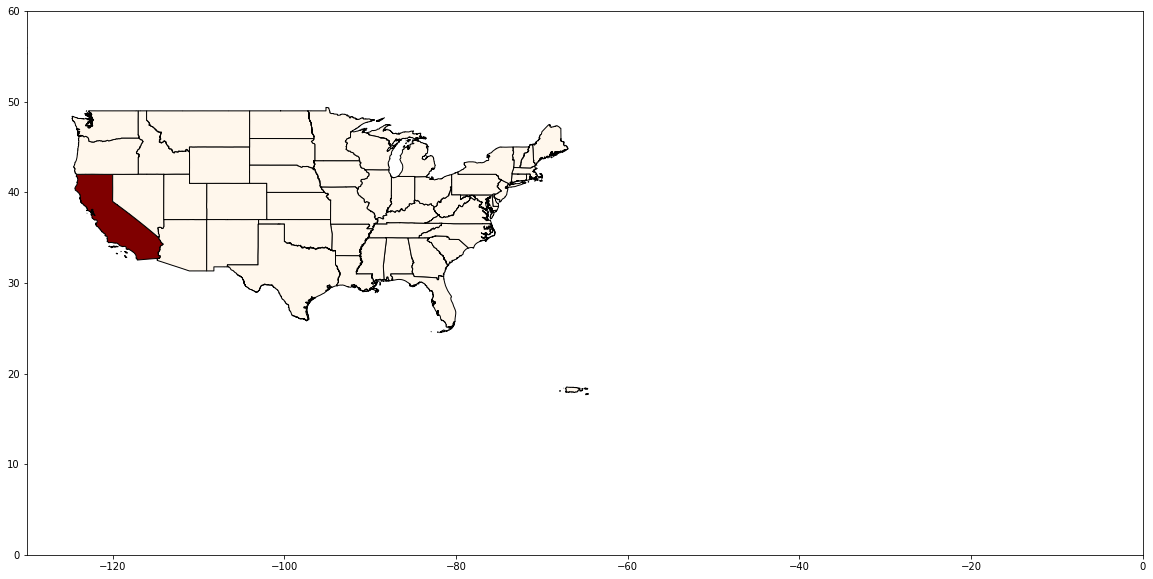

In [18]:
#ax = pl.figure(figsize=(20,10)).add_subplot(111)
#ax = states.plot(column='logcounts',cmap='OrRd', edgecolor='black', ax=ax);
#ax.set_xlim(-130, 0)
#ax.set_ylim(0, 60)


(0, 60)

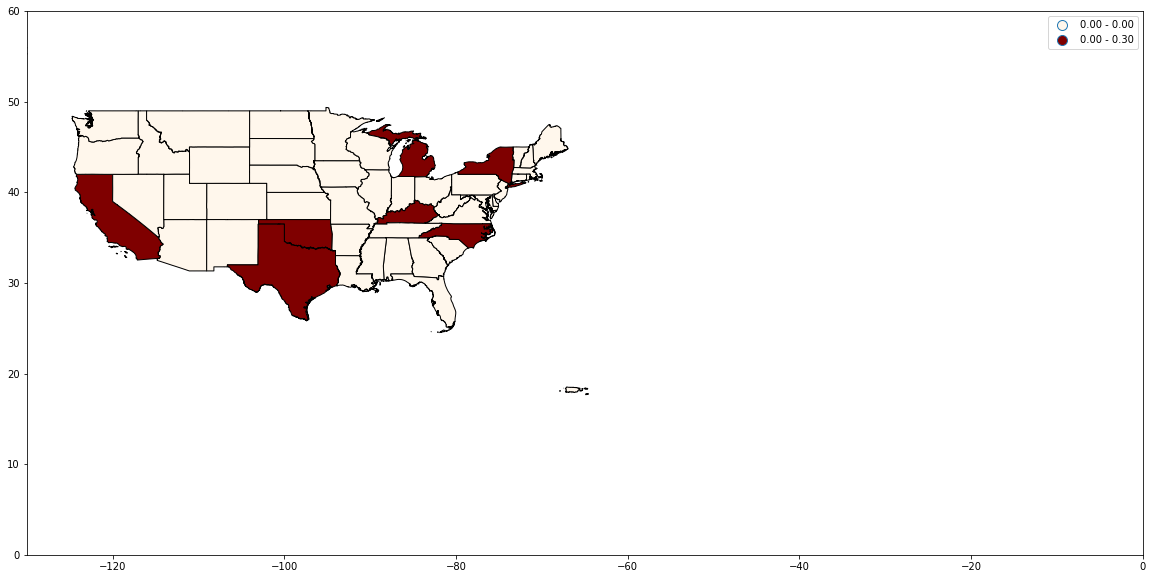

In [20]:
#ax = pl.figure(figsize=(20,10)).add_subplot(111)
#ax = states.plot(column='logcounts',cmap='OrRd', edgecolor='black', ax=ax, scheme='quantiles', legend=True);
#ax.set_xlim(-130, 0)
#ax.set_ylim(0, 60)


In [81]:
states[states['NAME'] == 'California']

,STATEFP,STATENS,AFFGEOID,GEOID,STUSPS,NAME,LSAD,ALAND,AWATER,geometry,counts,logcounts
index_left,,,,,,,,,,,,
4,06,01779778,0400000US06,06,CA,California,00,403501101370,20466718403,"(POLYGON ((-118.604415 33.478552, -118.598783 ...",1.0,0.30103


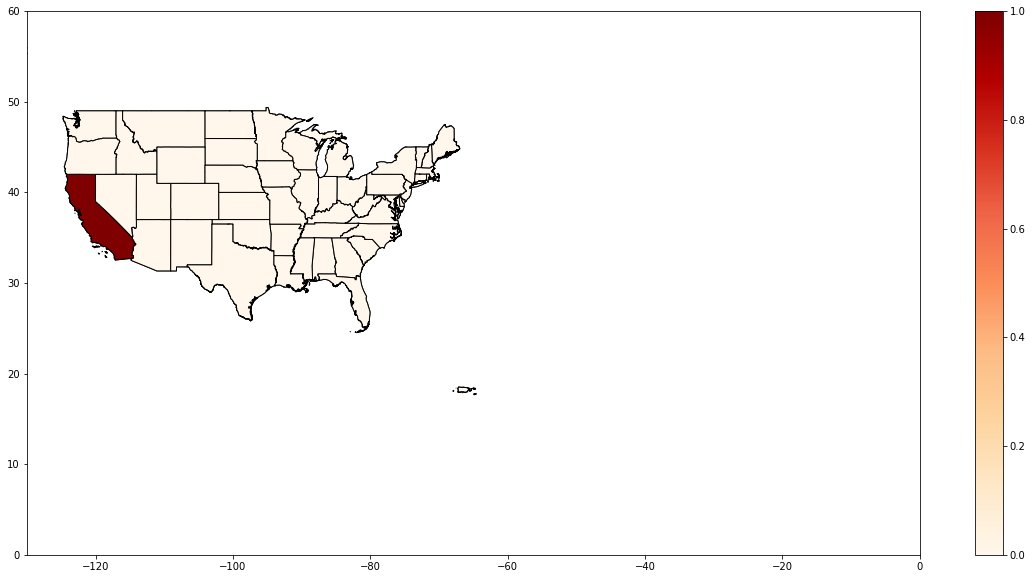

In [83]:
ax = pl.figure(figsize=(20,10)).add_subplot(111)
states.plot(color='w', edgecolor='k', ax=ax)
ax.set_xlim(-130, 0)
ax.set_ylim(0, 60)
states.plot(column='counts',cmap='OrRd', edgecolor='black', ax=ax, legend=True)


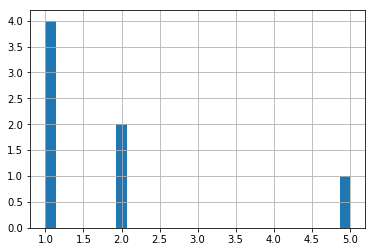

In [42]:
states[(states.counts > 0) & (states.counts < 2700)].counts.hist(bins=30)

In [46]:
states[states.NAME == 'California']

,STATEFP,STATENS,AFFGEOID,GEOID,STUSPS,NAME,LSAD,ALAND,AWATER,geometry,counts,logcounts
index_left,,,,,,,,,,,,
4,06,01779778,0400000US06,06,CA,California,00,403501101370,20466718403,"(POLYGON ((-118.604415 33.478552, -118.598783 ...",2778,3.443889


In [3]:
def get_data(file):
    user_jsons = []
    with open("data/" + file, 'rb') as f:
        for line in f:
            while True:
                try:
                    jfile = json.loads(line)
                    break
                except ValueError:
                    # Not yet a complete JSON value
                    line += next(f)
            user_jsons.append(jfile)
    return user_jsons
    

In [73]:
def make_gdf(jsons):
    longs = []
    lats = []
    name = []
    tweets = []
    for i in range(len(jsons)):
        if jsons[i]["coordinates"] is not None:
            longs.append(jsons[i]["coordinates"]["coordinates"][0])
            lats.append(jsons[i]["coordinates"]["coordinates"][1])
            tweets.append(jsons[i]['text'])
            name.append(jsons[i]["user"]["screen_name"])
            
    myDict = {"longs": longs, "lats": lats, "name":name}
    df = pd.DataFrame(myDict)
    geometry = [Point(xy) for xy in zip(df.longs, df.lats)]
    df = df.drop(['longs', 'lats'], axis=1)
    crs = {'init': 'epsg:4326'}
    gdf = gpd.GeoDataFrame(df, crs=crs, geometry=geometry)
    return gdf

In [26]:
def join_dfs(map_file, gdf):
    base = gpd.read_file(map_file)
    gdf = gdf.to_crs(base.crs)
    joined = gpd.sjoin(base, gdf, op='intersects', how='inner')
    counts = joined.groupby('NAME').size()
    counts = counts.to_dict()
    base['counts'] = base['NAME'].apply(lambda x:counts[x] if x in counts.keys() else 0)
    base['counts'] = base['counts'] / sum(base['counts'])
    base['logcounts'] = np.log10(base['counts']+1) 
    return base

In [40]:
def make_map(base):
    ax = pl.figure(figsize=(20,10)).add_subplot(111)
    #base.plot(color='w', edgecolor='k', ax=ax)
    ax.set_xlim(-130, 0)
    ax.set_ylim(0, 60)
    base[base.counts > 0].plot(column='counts',cmap='OrRd', edgecolor='black',
                                   ax=ax, scheme='quantiles', legend=True)

In [49]:
def make_cali_map(base):
    ax = pl.figure(figsize=(16,18)).add_subplot(111)
    #base.plot(color='w', edgecolor='k', ax=ax)
    base[base.counts > 0].plot(column='logcounts',cmap='OrRd', edgecolor='black',
                                   ax=ax, scheme='quantiles', legend=True)

In [7]:
data = get_data("2017-11-19_Police_tweets.json")

In [27]:
tweets = make_gdf(data)

In [28]:
joined = join_dfs("data/states/cb_2016_us_state_500k.shp", tweets)

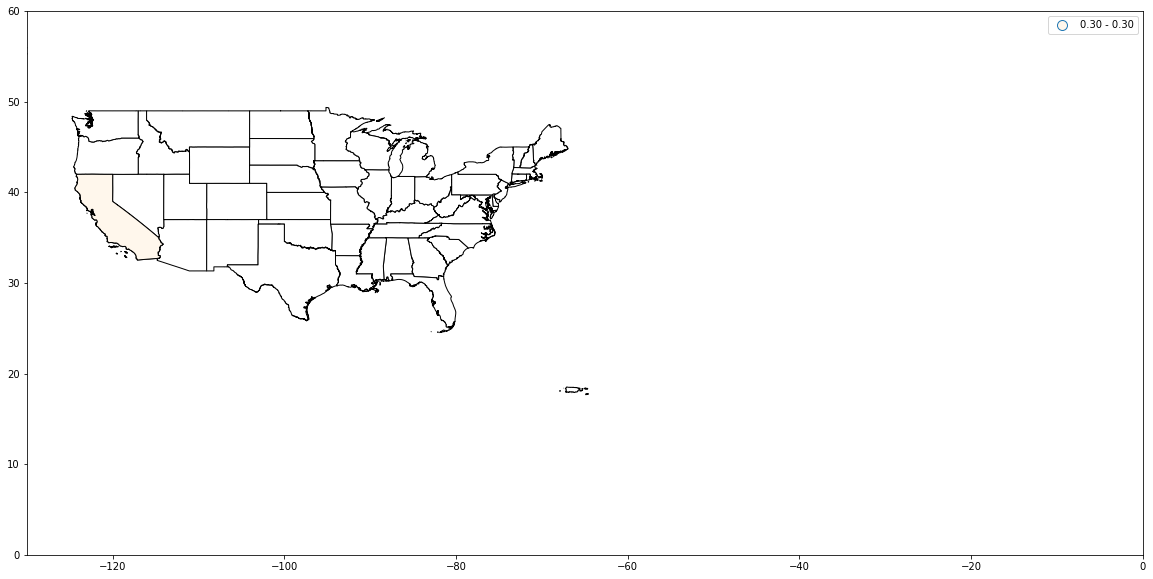

In [29]:
make_map(joined)

In [30]:
cali_tweets = make_gdf(data)

In [20]:
cali_tweets.head()

,name,geometry
0,rudeweatherbot,POINT (-120.5889957 38.3485621)
1,SCHJobs,POINT (-122.1802812 37.3813444)
2,panickiee,POINT (-120.71224688 38.74021821)
3,vapingmonkey,POINT (-117.83576161 34.02572912)
4,SQ4ME2,POINT (-119.72972051 36.48863024)


In [31]:
cali_joined = join_dfs("data/ca_counties/CA_Cities_TIGER2016.shp", cali_tweets)

In [33]:
cali_joined.head()

,STATEFP,COUNTYFP,COUNTYNS,GEOID,NAME,NAMELSAD,LSAD,CLASSFP,MTFCC,CSAFP,CBSAFP,METDIVFP,FUNCSTAT,ALAND,AWATER,INTPTLAT,INTPTLON,geometry,counts,logcounts
index_left,,,,,,,,,,,,,,,,,,,,
0,06,091,00277310,06091,Sierra,Sierra County,06,H1,G4020,None,None,None,A,2468694587,23299110,+39.5769252,-120.5219926,POLYGON ((-13431319.75097945 4821511.426395644...,0.000000,0.000000
1,06,067,00277298,06067,Sacramento,Sacramento County,06,H1,G4020,472,40900,None,A,2499183617,76073827,+38.4500114,-121.3404409,POLYGON ((-13490651.47641084 4680831.603393857...,0.002740,0.001188
2,06,083,00277306,06083,Santa Barbara,Santa Barbara County,06,H1,G4020,None,42200,None,A,7084000598,2729814515,+34.5370572,-120.0399729,(POLYGON ((-13423116.77225655 4042044.14856006...,0.012133,0.005238
3,06,009,01675885,06009,Calaveras,Calaveras County,06,H1,G4020,None,None,None,A,2641820834,43806026,+38.1838996,-120.5614415,"POLYGON ((-13428575.483353 4627725.227535474, ...",0.003131,0.001358
4,06,111,00277320,06111,Ventura,Ventura County,06,H1,G4020,348,37100,None,A,4773390489,945942791,+34.3587415,-119.1331432,(POLYGON ((-13317853.59433417 3931602.41399276...,0.013307,0.005741


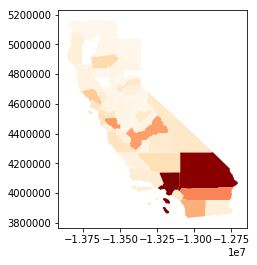

In [41]:
cali_joined[cali_joined.counts > 0].plot(column='counts', cmap='OrRd')

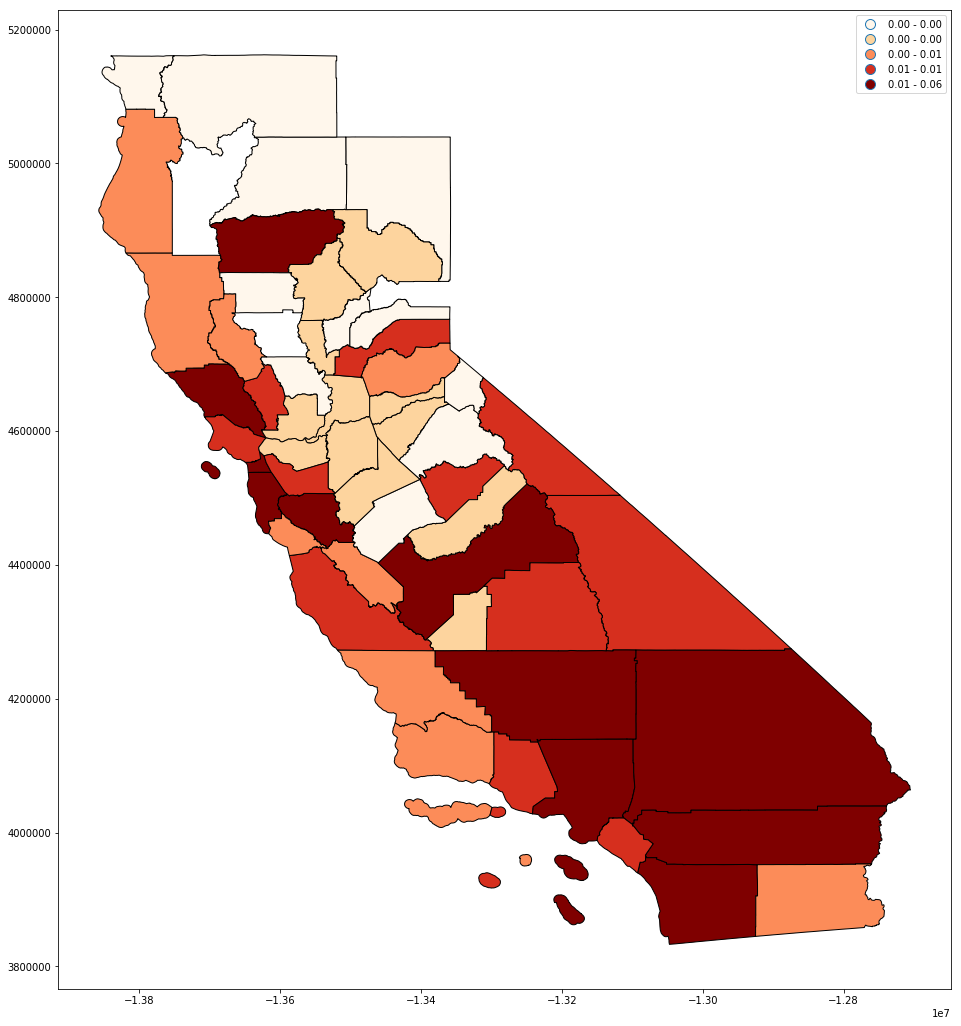

In [50]:
make_cali_map(cali_joined)

In [67]:
base = gpd.read_file("data/ca_tract/cb_2016_06_tract_500k.shp")

In [68]:
base = base[base.COUNTYFP == '071']

In [70]:
base.head()

,STATEFP,COUNTYFP,TRACTCE,AFFGEOID,GEOID,NAME,LSAD,ALAND,AWATER,geometry
341,06,071,009112,1400000US06071009112,06071009112,91.12,CT,4892476,0,"POLYGON ((-117.43445 34.507072, -117.434731 34..."
342,06,071,009712,1400000US06071009712,06071009712,97.12,CT,15037625,0,"POLYGON ((-117.190238 34.50057, -117.172741 34..."
343,06,071,009905,1400000US06071009905,06071009905,99.05,CT,9960843,123985,"POLYGON ((-117.338066 34.537277, -117.332874 3..."
344,06,071,010014,1400000US06071010014,06071010014,100.14,CT,3951345,0,"POLYGON ((-117.314442 34.429393, -117.31313 34..."
345,06,071,010300,1400000US06071010300,06071010300,103,CT,18005181823,8390739,"POLYGON ((-117.083126 35.272609, -117.080517 3..."


In [71]:
cali_tweets = cali_tweets.to_crs(base.crs)
joined = gpd.sjoin(base, cali_tweets, op='intersects', how='inner')
counts = joined.groupby('TRACTCE').size()
counts = counts.to_dict()
base['counts'] = base['TRACTCE'].apply(lambda x:counts[x] if x in counts.keys() else 0)
base['counts'] = base['counts'] / sum(base['counts'])
base['logcounts'] = np.log10(base['counts']+1) 

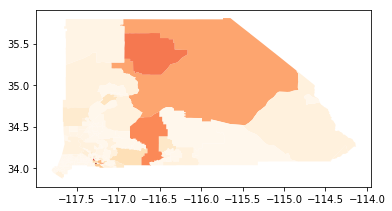

In [72]:
base.plot(column='counts',cmap='OrRd')

In [76]:
cali_joined[cali_joined.NAME == 'San Bernardino']

,STATEFP,COUNTYFP,COUNTYNS,GEOID,NAME,NAMELSAD,LSAD,CLASSFP,MTFCC,CSAFP,CBSAFP,METDIVFP,FUNCSTAT,ALAND,AWATER,INTPTLAT,INTPTLON,geometry,counts,logcounts
index_left,,,,,,,,,,,,,,,,,,,,
23,06,071,00277300,06071,San Bernardino,San Bernardino County,06,H1,G4020,348,40140,None,A,51948120575,123845026,+34.8572198,-116.1811967,POLYGON ((-13098659.03733252 4127837.220416734...,0.135421,0.055157


In [93]:
base = base.to_crs(epsg=3857)

In [94]:
frames = [cali_joined, base]

In [95]:
df = pd.concat(frames)

In [79]:
df.head()

,AFFGEOID,ALAND,AWATER,CBSAFP,CLASSFP,COUNTYFP,COUNTYNS,CSAFP,FUNCSTAT,GEOID,...,LSAD,METDIVFP,MTFCC,NAME,NAMELSAD,STATEFP,TRACTCE,counts,geometry,logcounts
index_left,,,,,,,,,,,,,,,,,,,,,
0,NaN,2468694587,23299110,None,H1,091,00277310,None,A,06091,...,06,None,G4020,Sierra,Sierra County,06,NaN,0.000000,POLYGON ((-13431319.75097945 4821511.426395644...,0.000000
1,NaN,2499183617,76073827,40900,H1,067,00277298,472,A,06067,...,06,None,G4020,Sacramento,Sacramento County,06,NaN,0.002740,POLYGON ((-13490651.47641084 4680831.603393857...,0.001188
2,NaN,7084000598,2729814515,42200,H1,083,00277306,None,A,06083,...,06,None,G4020,Santa Barbara,Santa Barbara County,06,NaN,0.012133,(POLYGON ((-13423116.77225655 4042044.14856006...,0.005238
3,NaN,2641820834,43806026,None,H1,009,01675885,None,A,06009,...,06,None,G4020,Calaveras,Calaveras County,06,NaN,0.003131,"POLYGON ((-13428575.483353 4627725.227535474, ...",0.001358
4,NaN,4773390489,945942791,37100,H1,111,00277320,348,A,06111,...,06,None,G4020,Ventura,Ventura County,06,NaN,0.013307,(POLYGON ((-13317853.59433417 3931602.41399276...,0.005741


In [80]:
base.head()

,STATEFP,COUNTYFP,TRACTCE,AFFGEOID,GEOID,NAME,LSAD,ALAND,AWATER,geometry,counts,logcounts
index_left,,,,,,,,,,,,
341,06,071,009112,1400000US06071009112,06071009112,91.12,CT,4892476,0,"POLYGON ((-117.43445 34.507072, -117.434731 34...",0.000000,0.000000
342,06,071,009712,1400000US06071009712,06071009712,97.12,CT,15037625,0,"POLYGON ((-117.190238 34.50057, -117.172741 34...",0.000000,0.000000
343,06,071,009905,1400000US06071009905,06071009905,99.05,CT,9960843,123985,"POLYGON ((-117.338066 34.537277, -117.332874 3...",0.000000,0.000000
344,06,071,010014,1400000US06071010014,06071010014,100.14,CT,3951345,0,"POLYGON ((-117.314442 34.429393, -117.31313 34...",0.000000,0.000000
345,06,071,010300,1400000US06071010300,06071010300,103,CT,18005181823,8390739,"POLYGON ((-117.083126 35.272609, -117.080517 3...",0.048851,0.020714


In [96]:
df = df[df.NAME != 'San Bernardino']

In [92]:
cali_joined.crs

{'init': u'epsg:3857'}

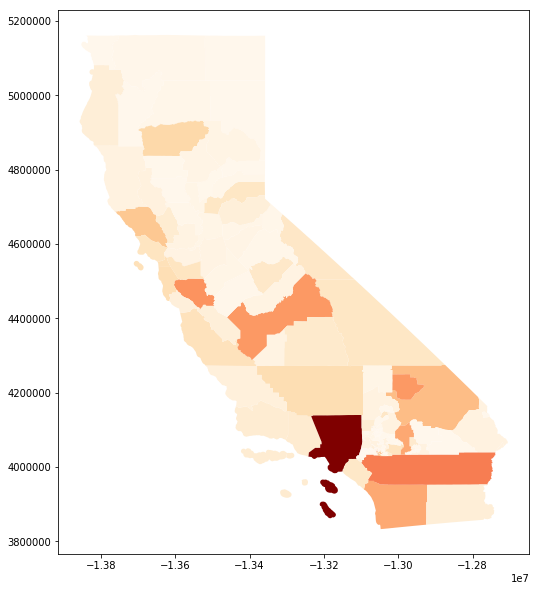

In [98]:
df.plot(column='logcounts', cmap='OrRd', figsize=(10, 10))